<h2 style='text-align: center;'> Final Project Code: </h2>
<h4 style='text-align: center; font-weight: normal;'> Developing a Prediction Model for Sales Prices using the Ames Housing Dataset</h4>
<h5 style='text-align: center; font-weight: normal;'> Aditya Pendyala </h5>
<h5 style='text-align: center; font-weight: normal;'> Michigan State University </h5>
<h5 style='text-align: center; font-weight: normal;'> STT 481: Capstone in Statistics </h5>
<h5 style='text-align: center; font-weight: normal;'> Dr. Yue Xing </h5>
<h5 style='text-align: center; font-weight: normal;'> April 12th, 2024 </h5>


<h4 style='text-align: left;'> 1.	Introduction, Exploratory Data Analysis, and Data Pre-Processing </h4>

**About the dataset:**

*This dataset, Ames Housing dataset, consists of 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa. It was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset.* 

*Firstly, importing all the necessary libraries for this project.*

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.metrics import r2_score

*Importing the train.csv and test.csv data using pandas.*

In [2]:
train_df = pd.read_csv("files/train.csv")
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


*Understanding the dataset by printing information like Na counts and datatypes for each column.*

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

*Dropping columns that have a considerable number of Na(s) and printing the shape of the resulting dataframe*

In [4]:
train_df_col_drop = train_df.drop(columns = ['Id', 'Alley','MasVnrType','FireplaceQu','PoolQC','Fence','MiscFeature'])
print(train_df_col_drop.shape)

(1460, 74)


*Now replacing Na values with values right above Na value row using ffill method. Sorting each column in ascending order before filling to fill Na(s) with closest possible values.* 

In [5]:
filled_train_df = train_df_col_drop.apply(lambda x: x.sort_values().fillna(method='bfill'))

*Plotting histograms for features with float and integer data types.*

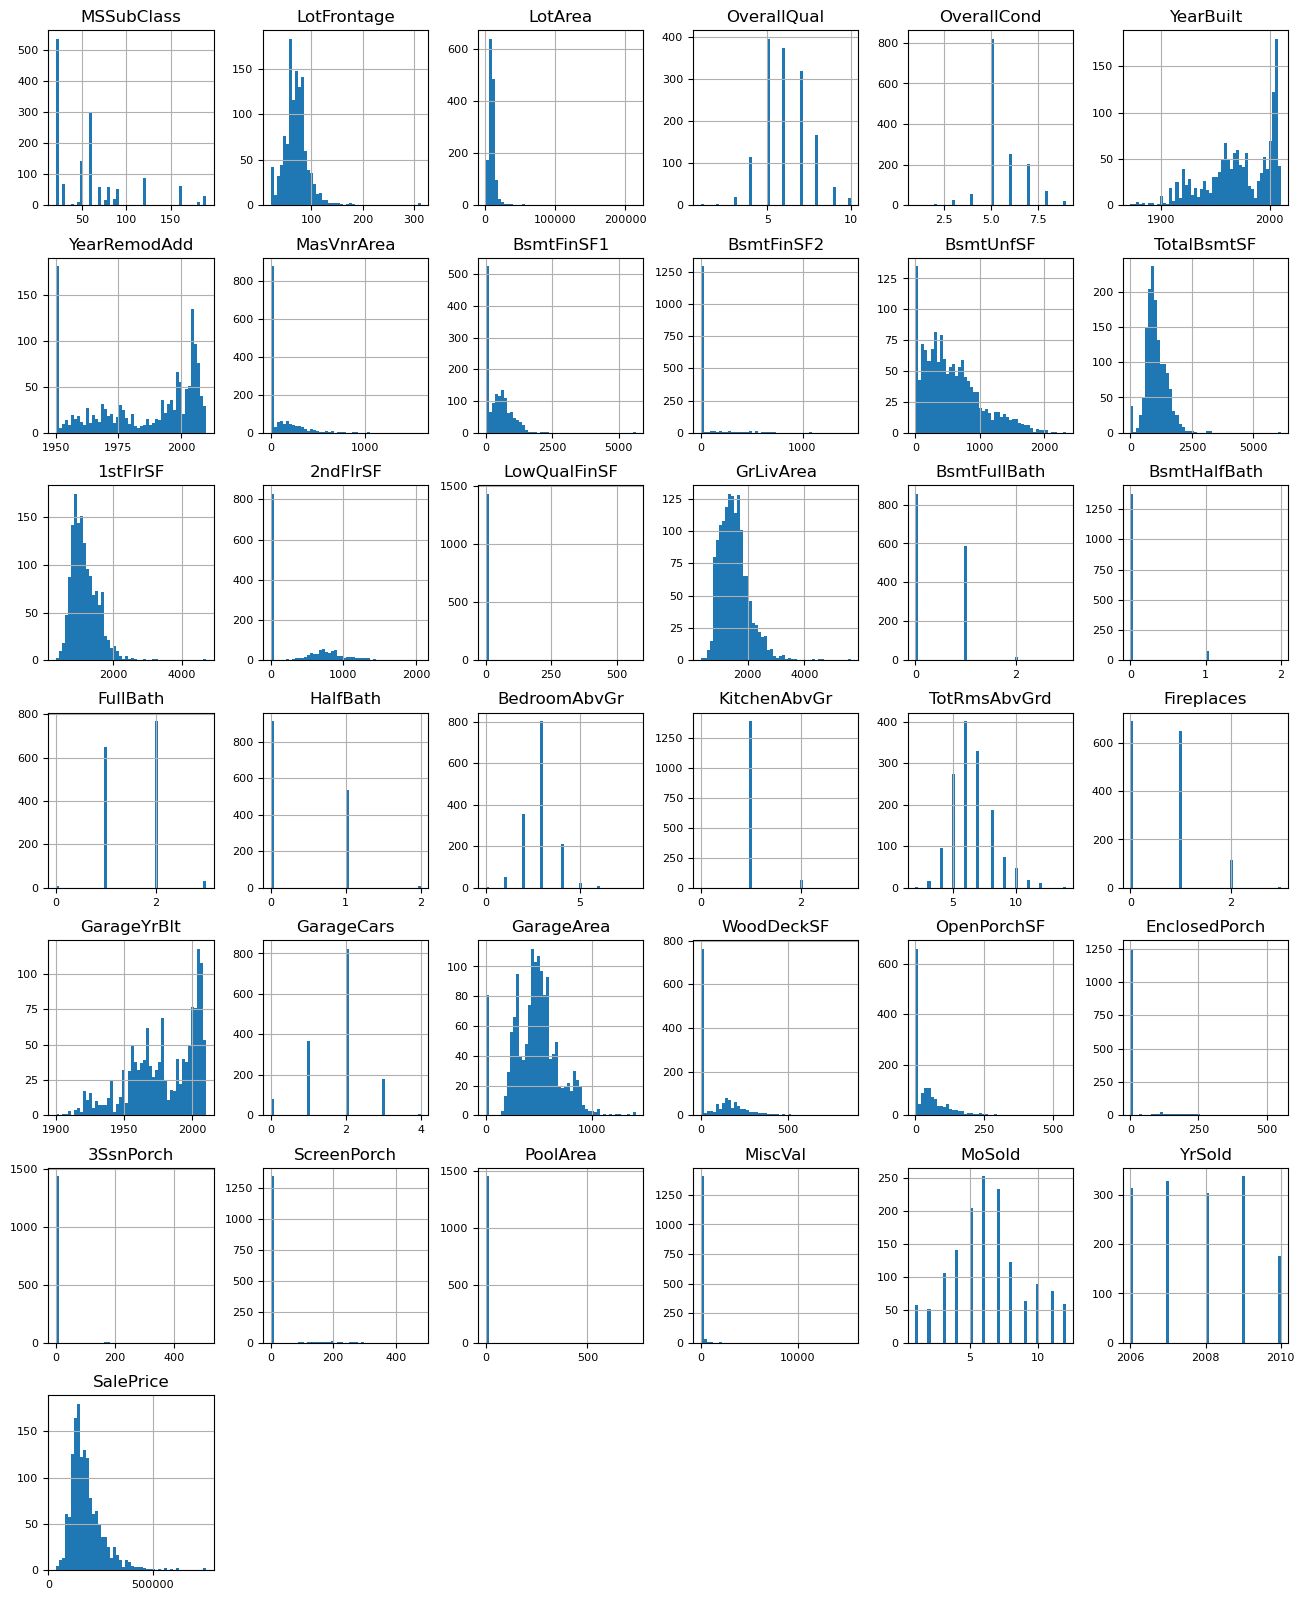

In [6]:
train_df_numeric = filled_train_df.select_dtypes(include = ['float64', 'int64'])
train_df_numeric.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

*Plotting a Correlation plot showing variables with values above 0.60.*

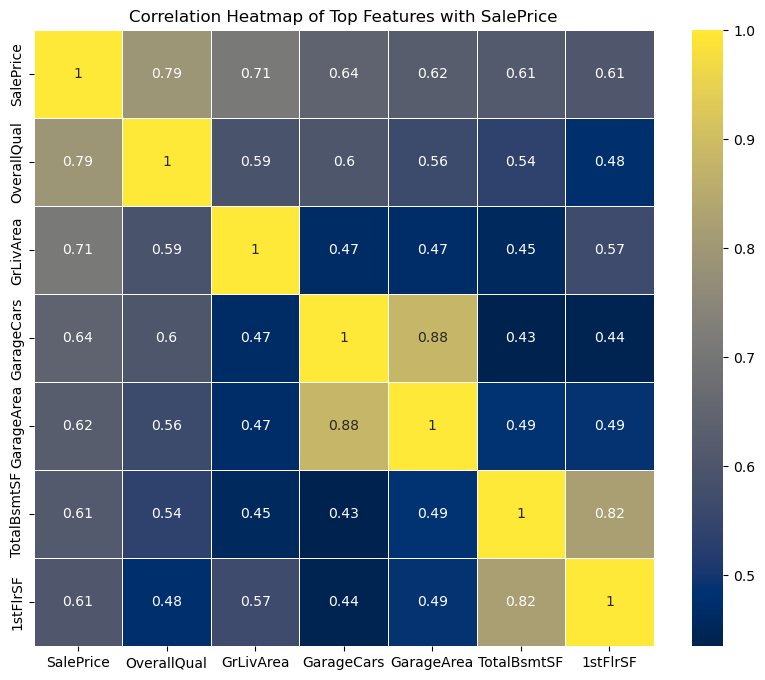

In [7]:
# Encoding string columns
train_encoded = pd.get_dummies(filled_train_df)

# Calculating the correlation matrix
corr_matrix = train_encoded.corr()
saleprice_corr = corr_matrix['SalePrice'].sort_values(ascending=False)

# Plotting the top correlated features (correlation greater than 0.6)
top_corr_features = saleprice_corr[abs(saleprice_corr) > 0.60]  
plt.figure(figsize=(10, 8))

#Choosing cividis color scheme for maximum accessibility and creating a heatmap
sns.heatmap(train_encoded[top_corr_features.index].corr(), annot=True, cmap='cividis', linewidths=0.5)
plt.title('Correlation Heatmap of Top Features with SalePrice')
plt.show()

<h3 style='text-align: left;'> 2. Algorithm, Cross Validation, and Hyper-parametric Tuning </h2>

*Splitting the dataset into features (X) and target variable (y)*

In [8]:
# Splitting the dataset into features (X) and target variable (y)
X = train_encoded.drop(columns=['SalePrice'])
y = train_encoded['SalePrice']

# Splitting the data into training and testing sets (70-30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


*Training XG Boost models. First a hyper-parameterized model, and then a preliminary model.*

In [9]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree' : [0.3, 0.5, 0.7]
}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, device = "cuda")
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=parameters, cv=3, n_jobs=-1, verbose=True)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}
Best score: 0.8820152536433256


In [10]:
# Initiating the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Training the model on the training data
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

<h3 style='text-align: left;'> 3. Fitting the Model </h2>

*Testing both XGBoost models with testing data, and comparing using R squared values.*

In [11]:
# Predicting on the testing data
y_pred_grid = grid_search.predict(X_test)

# Calculating the R-squared score
r_squared_grid = r2_score(y_test, y_pred_grid)
print("R-squared score:", r_squared_grid)

R-squared score: 0.9235946935780777


In [12]:
# Predicting on the testing data
y_pred = xgb_reg.predict(X_test)

# Calculating the R-squared score
r_squared = r2_score(y_test, y_pred)
print("R-squared score:", r_squared)


R-squared score: 0.9021205043928403


*Plotting GridSearch CV's parameters with their corresponding Mean test scores.*

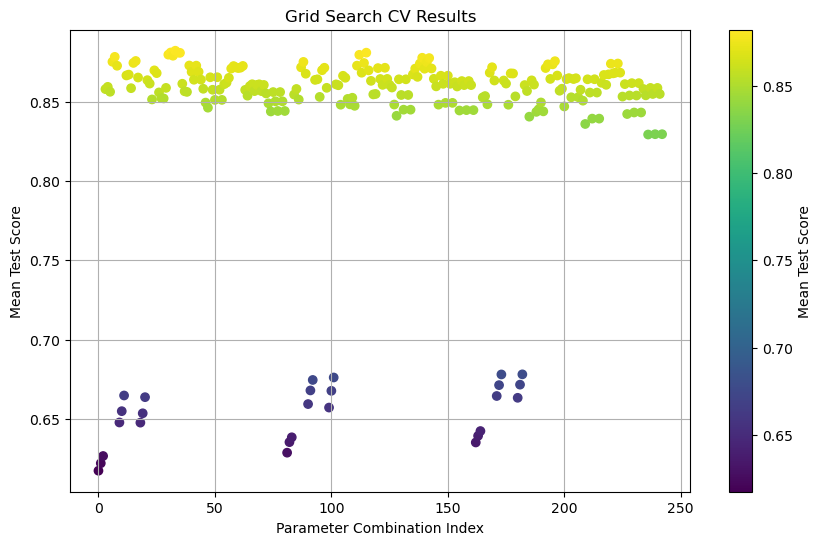

In [13]:
import matplotlib.pyplot as plt
import numpy as np

mean_test_scores = grid_search.cv_results_['mean_test_score']

# Creating the plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(mean_test_scores)), mean_test_scores, c=mean_test_scores, cmap='viridis', marker='o')
plt.colorbar(label='Mean Test Score')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Mean Test Score')
plt.title('Grid Search CV Results')
plt.grid(True)
plt.show()


*Plotting both the preliminary and hyper-parametrized XG-Boost models. The
closer the datapoints to the dashed line, more the accuracy. We can see that the blue dots are fairly closer to the dashed line than the orange dots.*

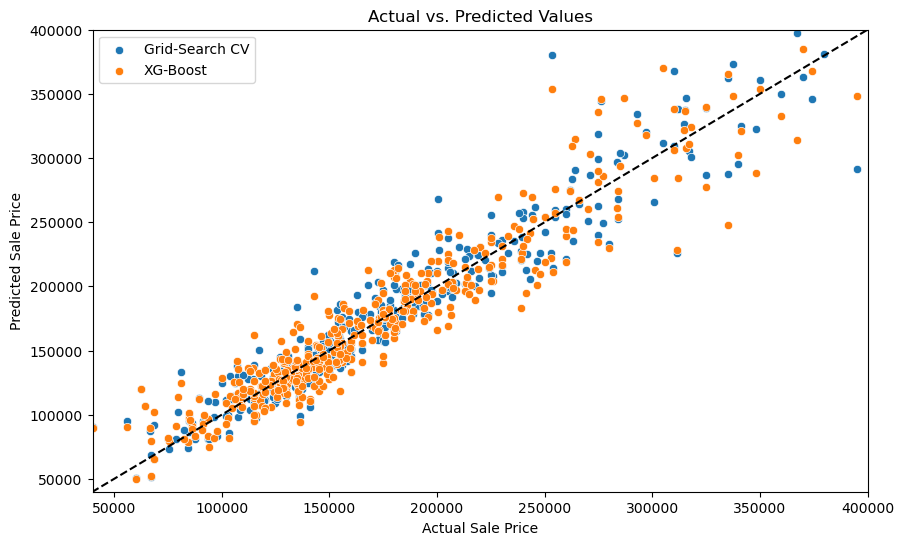

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_grid, label = 'Grid-Search CV')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')  # Line representing perfect predictions
sns.scatterplot(x=y_test, y=y_pred, label = 'XG-Boost')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.xlim(40000, 400000)
plt.ylim(40000, 400000)
plt.legend()
plt.show()


*Plotting the top 10 features with the highest importance to the XG Boost model.*

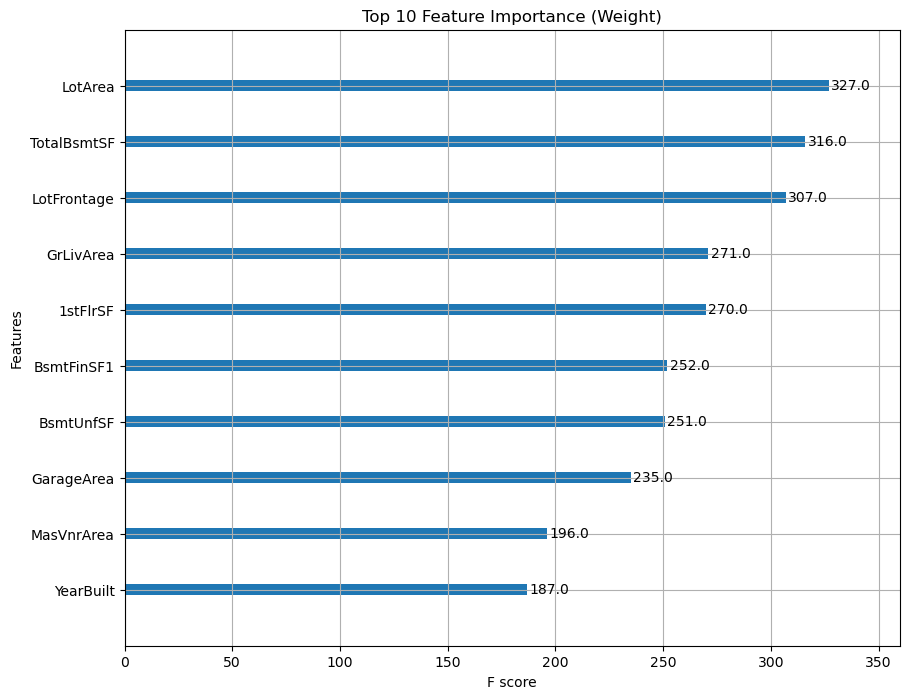

In [24]:
import matplotlib.pyplot as plt

# Extracting the best estimator from Grid Search
best_model = grid_search.best_estimator_

# Getting feature scores and names
feature_scores = best_model.get_booster().get_score(importance_type='weight')
features_df = pd.DataFrame(list(feature_scores.items()), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False)

# Selecting the top 10 features
top_features_df = features_df.head(10)

# Plotting feature importance for the top 10 features by weight
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10, title='Top 10 Feature Importance (Weight)', ax=ax)
plt.show()


<h3 style='text-align: left;'> 4. Pre-processing testing data </h2>

In [15]:
#Loading the test.csv file
test_df = pd.read_csv('files/test.csv')
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
#Giving the data the same treatment as train.csv

In [16]:
filled_test_df = test_df.apply(lambda x: x.sort_values().fillna(method='bfill'))

# Encoding categorical variables
test_encoded = pd.get_dummies(filled_test_df)

# Checking for any columns in X_train that are not in test_encoded and add them with 0 values
missing_cols = set(X_train.columns) - set(test_encoded.columns)
for c in missing_cols:
    test_encoded[c] = 0

# Ensuring the order of columns in test matches that of X_train
test_encoded = test_encoded[X_train.columns]

# Displaying the first few rows of the processed test set to confirm preparation
test_encoded.head()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0,0,0,1,0,0,0,0,1,0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,0,0,0,1,0,0,0,0,1,0
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [17]:
# Prediction on testing data
predicted_test_values_cv = grid_search.predict(test_encoded)

In [18]:
# Creating a DataFrame with IDs from the test set and the corresponding predicted SalePrice
output_df = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predicted_test_values_cv
})

# Saving this DataFrame to a CSV file
output_csv_path = 'files/predicted_sale_prices_cv.csv'
output_df.to_csv(output_csv_path, index=False)